<h1>Dynamic Programming: Policy Iteration (Synchronous)</h1>

<h2>Gridworld Example</h2>

Dynamic programming can be used to find an optimal policy $\pi_*$ to guide an agent along the shortest path from any square in the maze to the finish line square.

This notebook contains a solution to the Gridworld poblem using [Policy Iteration](#policy-iteration) methods.


The Gridworld experiment described in this notebook makes the following asssumptions:<br>
1. The environment has a fully specified model of its transition probabilities which can be accessed by the agent.

2. The maze is constructed from a grid whose size (i.e. number of states) is small enough to allow the agent to sweep through the state-space within a relatively short period of time.</dd>


<h2>Environment: Gridwolrd</h2>


The Gridwolrd environemnt is composed of a class containing the maze itself, the possible actions allowed within the environment and helpoer functions to compute rewards and transition probabilties of the possible moves available. See the [Gridworld environment class notebook](envGridworld.ipynb) for details of this class. 

<center><img src="images\gridworld_grid.png"/></center>

<h3>Environment Gridworld: Maze</h3>

The maze is represented as a 20x20 numpy array of integers where each elelment of the 2D array represents a position in the maze and the value of each element signifies whether the position can be occupied by the agent or if the position is a wall.

$$
\large maze[i,j]
= 
\begin{cases}
0\quad\quad \,\,\,\,\,\,maze[i,j]\normalsize\text{ is not a wall } \\
-1\quad\,\,\,\,\,\,\,\,maze[i,j]\normalsize\text{ is a wall}
\end{cases}
$$

<h3>Environment Gridworld: States</h3>

Each white square in the maze represents a state which is a random variable which we denote as $S$.<br> Each observed state $s\in S$ is defined as an ordered pair $(x,y)$ which represents the position of the agent on the grid.
$$\large S\coloneqq\{(x, y): (x\in\mathbb{Z}) \cap (0\le x<n) \bigcap (y\in\mathbb{Z}) \cap (0\le y<m)\}$$

<h3>Environment Gridworld: Actionss</h3>

Each action is a random variable which we denote with the symbol $A$ and there are four actions available to the agent.<br>
$$\large A\coloneqq\{Up, Down, Left, Right\}$$

<h3>Environment Gridworld: Rewards</h3>

At each time step the reward of an action taken is either -1 or 0 depending upon whether the next state is a finish line or non-finish line square on the grid. 

$$
\large R_t
= 
\begin{cases}
0\quad\quad \Large s_{t+1}\normalsize =\text{ finish line square on the grid } \\
-1\quad\, \Large s_{t+1}\normalsize\neq\text{ finish line square on the grid}
\end{cases}
$$

<h3>Environment Gridworld: Transitions</h3>

The transition probabilities used by the Gridwold environment assume that the probability of moving to the next state (i.e. square in the maze) given any any action $a \in A$ from any current state $s \in S$ is equal to 1. More simply there is only one possible next state $s' \in S$ for each action $a \in A$.

$$\large P(S_{t+1}=s_{t+1}|S_t=s_t, A=a_t) = 1 \qquad \forall \,s_{t+1}, s_t \in S,\, a_t \in A$$

<h2>Policy</h2>

Our agent's policy is denoted as $\pi$ and is used to represent the conditional probability mass function $f_{A|S}$ of actions over the states:<br>
$$\large \pi\coloneqq f_{A|S}$$

At any given timestep $t$, our agent must choose an action $a\in A$ to move from its current state $s\in S$ to its next state $s'\in S$.

We denote the conditional probability of our agent selecting action $a\in A$ given its current state $s\in S$ by the following notation:
$$\large \pi(a|s)=f_{A|S}(a|s)=P(A=a|S=s)$$



A policy used in Gridworld is represented by an $mxnx|S|$ numpy array pi where each element represents the probability of taking action $a\in A$ while in the state $s=(i,j)$

As an example a random policy, example_pi, for taking actions $A$ with equal probability in a $2x2$ maze would have the shape (2,2,4).

In [2]:
import numpy as np

In [3]:
example_pi = np.zeros((2,2,4),dtype=np.float32)
example_pi[:] = 0.25
print(example_pi)
example_pi.shape

[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]]


(2, 2, 4)

<h2>State Value Function</h2>


An $mxn$ matrix $V$ is used to store the values of each state $v_\pi(s)$ on the grid where, according to the Bellman equations, the state value represents the expected return of the current state while folowing policy $\pi.\,\,$[\[1\]](#References)<br>


$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad v_\pi(s_t) \coloneqq \mathbb{E} [G_t | S_t=s_t]$<br>
$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad= \mathbb{E} [R_{t+1} + \gamma G_{t+1} | S_t=s_t]$<br>
$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad=\mathbb{E} [R_{t+1} + \gamma v_\pi (S_{t+1}) | S_t=s_t] $<br>
$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad=\sum\limits_{a} \pi(a|s_t) \sum\limits_{s_{t+1}} \sum\limits_{r} p(s_{t+1}, r| s_t, a)[r+\gamma v_\pi(s_{t+1})] $


As an example the 2D numpy array V for a maze of shape $2x2$ represents the state value $v_\pi(s)$ for each $s\in S$ and would have the shape (2,2).

In [4]:
example_V = np.random.sample((2,2))
print(example_V)
example_V.shape

[[0.72495277 0.1115894 ]
 [0.82204285 0.46985673]]


(2, 2)

<h2>Policy Evaluation</h2>

The Policy Evaluation algoritm iteratively evaluates the Bellman equation for the state value function according to the follwowing update rule.

$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad v_{k+1}(s_t) \coloneqq \mathbb{E} [R_{t+1} + \gamma v_k(S_{t+1}) | S_t=s_t] $<br>

$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad=\sum\limits_{a} \pi(a|s_t) \sum\limits_{s_{t+1}} \sum\limits_{r} p(s_{t+1}, r| s_t, a)[r+\gamma v_k(s_{t+1})] $


The sequence ${v_k}$ converges to $v_\pi$ as $k\rightarrow\infty$. Therefore this update rule is applied until the state value for all states does not change by an amount more than some tolearnce.[\[2\]](#References)

> <h2>Policy Evaluation Algorithm Psuedocode</h2>

The Policy Evaluation algoirthm can be used to estimate the state values, $V(s)\approx v_\pi(s)$, for all states $s\in S$ of the Gridworld environment. [\[3\]](#References)

$\large\quad\text{Policy Evaluation Algorithm: evaluatePolicy}$<br>
$\large\quad\text{Inputs: }environment,\,\,V,\,\,\pi,\,\,\gamma,\,\,tolerance$<br>

$\large\quad\quad\text{1.}\quad\,\delta \leftarrow \infty$<br>
$\large\quad\quad\text{2.}\quad\text{Loop while}\,\delta > tolerance$:<br>
$\large\quad\quad\text{3.}\quad\quad\delta \leftarrow 0$<br>
$\large\quad\quad\text{4.}\quad\quad\text{Loop over each}\,s \in S$:<br>
$\large\quad\quad\text{5.}\quad\quad\quad\quad v \leftarrow V(s)$<br>
$\large\quad\quad\#\quad\quad\quad\quad V(s) \leftarrow \sum\limits_a \pi(a|s_t) \sum\limits_{s_{t+1}} \sum\limits_{r} p(s_{t+1}, r | s_t, a)[r + \gamma V(s_{t+1})]$<br> 
$\large\quad\quad\text{6.}\quad\quad\quad\quad V(s) \leftarrow updateStateValue(environment,\,\,V,\,\,\pi,\,\,state,\,\,\gamma)$<br>
$\large\quad\quad\text{7.}\quad\quad\quad\quad\delta \leftarrow max(\delta, |v-V(s)|)$<br>
$\large\quad\quad\text{8.}\quad\text{Return } V$<br>

Note: Step 6 uses an in-place evaluation of $V(s)$ hence the absence of the time subscripted notation.

<h2>Policy Evaluation Algorithm Code</h2>

In [5]:
# Helper code for step 4 of Policy Evaluation Algorithm
# 4. Update V(s) with expected return of next state given action a and state s
def updateStateValue(environment, V, pi, state, gamma):
    v_s_temp = 0
    (i, j) = state
    for a in environment.Actions:
        if (a == 'up'):
            p_a_given_s = pi[i,j,0]
            a = 0;                    
        if (a == 'down'):
            p_a_given_s = pi[i,j,1]
            a = 1;
        if (a == 'left'):
            p_a_given_s = pi[i,j,2]
            a = 2;
        if (a == 'right'):
            p_a_given_s = pi[i,j,3]
            a = 3
        sum_sp_r = 0
        (i_next, j_next), r, p = environment.transitions(state=state, action=a)        
        sum_sp_r +=  p * (r + gamma * V[i_next, j_next])
        v_s_temp += p_a_given_s * sum_sp_r
    V[state[0],state[1]] = v_s_temp
    return V[state[0], state[1]]

In [6]:
# Policy Evaluation Algorithm
def evaluatePolicy(environment, V, pi, gamma, tolerance):
    # 1. Initialize delta to infinity
    delta = float('inf')
    # Loop while delta < tolerance
    while (delta > tolerance):
        # 2. delta = 0
        delta = 0
        # Loop over each state s in S
        for i in range(environment.States.shape[0]):
            for j in range(environment.States.shape[1]):
                if (environment.Maze[i,j] == -1):
                    continue
                state = tuple(environment.States[i,j])
                # 3. v = V(s)
                v = V[i,j]
                # 4. Update V(s) with expected return (See update_bellman_state_value_function in cell above)
                V[i,j] = updateStateValue(environment=environment, V=V, pi=pi, state=state, gamma=gamma) 
                # 5. delta = max(delta, abs(v-V(s))
                delta = max(delta, abs(v - V[i,j]))
    #6. Return V(s)
    return V


<h2>Policy Improvement Algorithm</h2>

Performing the Policy Evaluation algorithm above provides a means to finding better policies. According to the Policy Improvement theorem, an improved policy can be obtained with each subsequently better estimate of V found via the Policy Evaluation algorithm. The new improved policy is determined by 'greedifying' the old policy according to the most recently updated state values. Greedification of a policy entails selecting which action(s) maximize the expected returns among all actions over all possible state changes. [\[4\]](#References)   

$$\large\pi'(a|s_t)=\underset{a}{\operatorname{\arg\max}}\sum\limits_{s_{t+1}}\sum\limits_{r} P(s_{t+1},\,r|s_t,\,a)[r + \gamma\,V(s_{t+1})]$$

$\large\quad\text{Policy Improvement Algorithm: improvePolicy}$<br>
$\large\quad\text{Inputs: }environment,\,\,V,\,\,\pi,\,\,\gamma$<br>

$\large\quad\quad\text{1.}\quad\text{policy-stable} \leftarrow \text{True}$<br>
$\large\quad\quad\text{2.}\quad\text{Loop over each }\, s \in S$:<br>
$\large\quad\quad\text{3.}\quad\quad\quad\text{old}\leftarrow \pi$<br>
$\large\quad\quad\#\quad\quad\quad\pi(a|s_t)\leftarrow \underset{a}{\operatorname{\arg\max}} \sum\limits_{s_{t+1}}\sum\limits_{r} P(s_{t+1},\,r|s_t,\,a)[r + \gamma\,V(s_{t+1})]$<br>
$\large\quad\quad\text{4.}\quad\quad\quad\pi(a|s_t)\leftarrow\,\,qGreedifyPolicy(environment,\,\,V,\,\,s_t,\,\,\gamma)$<br>
$\large\quad\quad\text{5.}\quad\quad\quad\text{If old} \ne \pi \text{, then policy-stable} \leftarrow\text{False}$<br>
$\large\quad\quad\text{6.}\quad\text{Return }\pi \text{, policy-stable}$

Note: Step 4 uses an in-place evaluation of $\pi'(a|s_t)$ hence the absence of the prime notation.

<h2>Policy Improvement Code</h2>

In [7]:
# 4. Helper function to perform a greedy update of the policy (see #4 in the psuedocode above)
def qGreedifyPolicy(environment, V, state, gamma):
    i, j = state
    max_sum_sp_r = (float)("-inf")
    arg_max = []
    for a in environment.Actions:
        if (a == "up"):
            a = 0                    
        if (a == "down"):
            a = 1
        if (a == "left"):
            a = 2
        if (a == "right"):
            a = 3

        sum_sp_r = 0
        (i_next, j_next), r, p = environment.transitions(state=state, action=a)
        sum_sp_r += p * (r + gamma * V[i_next, j_next])
        
        if (sum_sp_r > max_sum_sp_r):
            max_sum_sp_r = sum_sp_r
            arg_max = []
        if (sum_sp_r == max_sum_sp_r):
            arg_max.append(a)
    
    pi_a_given_s = np.zeros((4,))#np.shape(pi_A_given_s))
    #    
    # pi[i,j,k] = p(a|s) =  {   
    #                           0,              a not in arg_max
    #                           1/len(arg_max),  a in arg_max
    #                       }
    
    for k in np.arange(4):
        if (k in arg_max):
            pi_a_given_s[k] = 1.0 / len(arg_max)

    return pi_a_given_s

In [8]:
def improvePolicy(environment, V, pi, gamma):
    # 1. Set policy_stable to True
    policy_stable = True
    # 2. Loop over all states s in S
    for i in range(environment.Maze.shape[0]):
        for j in range(environment.Maze.shape[1]):
            if (environment.Maze[i,j] == -1):
                continue
            state = tuple(environment.States[i,j])
            # 3. Set old to copy of policy
            old = pi.copy()
            # 4. Perform a greedy update of the policy (see #4. helper function in cell above)
            pi[i,j] = qGreedifyPolicy(environment=environment, V=V, state=state, gamma=gamma)
            # 5. Compare new greedified policy with the old policy
            if ( not np.array_equal(pi, old) ):
                policy_stable = False
    # 6. Return the greedified policy and the policy_stable variables
    return pi, policy_stable

<a id="policy-iteration"></a>

<h2>Policy Iteration</h2>

The Policy Itertion algoritm carries out a alternating sequence of evaluation and improvement steps until a stable optimal policy is found.[\[5\]](#References)

$$\Large \pi_0 \xrightarrow{\text{E}} v_{\pi0} \xrightarrow{\text{I}} \pi_1 \xrightarrow{\text{E}} v_{\pi1} \xrightarrow{\text{I}} \pi_2 \xrightarrow{\text{E}} \cdots \xrightarrow{\text{I}} \pi_* \xrightarrow{\text{E}} v_*$$

<h2>Policy Iteration Algorithm</h2>

Since greedifying a policy using the most recent estimate of the state values provides an improved policy as discussed above, we can monotonically improve the policy by evaluating the new policy and greedifying the previous policy again. In fact this can be done over and over again until either the state values or the policy do not change. It is at this point the new policy guaranteed to be optimal.[\[5\]](#References)

$\large\quad\text{Policy Iteration Agorithm: policyIteration}$<br>
$\large\quad\text{Inputs: environment, }\gamma, \text{ tolerance}$<br>

$\large\quad\quad\text{1.}\quad\quad V\leftarrow m x n\text{ matrix where }V[i,j]=\text{ random float } \forall\, i,j$<br>
$\large\quad\quad\text{2.}\quad\quad\pi\leftarrow mxnx|A|\text{ matrix where}\pi[i,j,a]=0.25\,\,\forall\,i,j,a$<br>
$\large\quad\quad\text{3.}\quad\quad\text{policy-stable}\leftarrow False$<br>
$\large\quad\quad\text{4.}\quad\quad\text{Loop while policy-stable is False:}$<br>
$\large\quad\quad\text{5.}\quad\quad\quad V\leftarrow\text{Evaluate Policy}(maze, V, \pi, \gamma, tolerance)$<br>
$\large\quad\quad\text{6.}\quad\quad\quad\pi\text{, policy-stable}\leftarrow\text{Policy Improvement}(maze, V, \pi,\gamma)$<br>
$\large\quad\quad\text{7.}\quad\quad\text{Return } V \approx v_* \text{ and } \pi \approx \pi_*$

In [9]:

def policyIteration(environment, gamma, tolerance):
    # 1. Initialize V(s) to random float for all states 
    V = 5 * np.random.sample((environment.Maze.shape[0], environment.Maze.shape[1]))
    for i in range(environment.Maze.shape[0]):
        for j in range(environment.Maze.shape[1]):
            if (environment.Maze[i,j] == -1):
                V[i,j] = (float)('-inf')
                continue
    
    # 2. Initialize pi(s) to equal probabilities 0.25 for all s in S
    pi = np.ones((environment.Maze.shape[0], environment.Maze.shape[1], len(environment.Actions))) / len(environment.Actions)
    pi[:,:,:] = 0.25

    # 3. Set policy_stable to False
    policy_stable = False
    count = 0
    # 4. Loop while policy_stable is false
    while ( not policy_stable ):
        # 5. Evaluate Policy
        V = evaluatePolicy(environment=environment, V=V, pi=pi, gamma=gamma, tolerance=tolerance)
        # 6. Improve policy
        pi, policy_stable = improvePolicy(environment=environment, V=V, pi=pi, gamma=gamma)
        count = count+1
        path_to_policy_fig = h.plotValuesPolicy(values=V, pi=pi, count=count, mask=environment.Mask, type='policy_iteration')
    # 7. Return the new state values V and the new policy pi
    return V, pi, path_to_policy_fig


<h2>Perform Policy Iteration Algorithm On The Gridworld Environment</h2>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
from IPython.display import Image
import seaborn as sns
import import_ipynb
import ipynb.fs.full.envGridworld as gw
import ipynb.fs.full.helpers as h

In [11]:
# Set the discount factor gamma for rewards
gamma = 0.99

# Set a tolerance for comparison of updated state values for policy evaluation
tolerance = 0.0000000001

# Select a square in the Gridworld maze to act as the finish line square
finish_position = (0,19)

An environment can be instantiated by simply choosing a finish position and then calling the envGridworld constructor which takes a path to a numpy array representing the maze and the selected finishing square position as a tuple.

In [12]:
# Instantiate a Gridworld environment
gridworld = gw.envGridworld(path_to_maze="./maze.npy", finish_position=finish_position)

Now run the policyIteration algorithm on the Gridworld environmnet object using $\gamma$ and tolerance parameters set above.

In [13]:
# Run the policy iteration algorithm on the gridworld environment and parameters set in the previous cell
V_star, pi_star, path_to_policy_fig = policyIteration(environment=gridworld, gamma=gamma, tolerance=tolerance)


<h2>Policy Iteration Results for Gridworld</h2>

The resulting optimal policy and state values are provided in the figure below. Each square in the grid contains:
1. the next action (or set of actions) provided by the optimal policy $\pi_*$
2. the optimal state value $v_*(s_t)$ for the position on the grid.

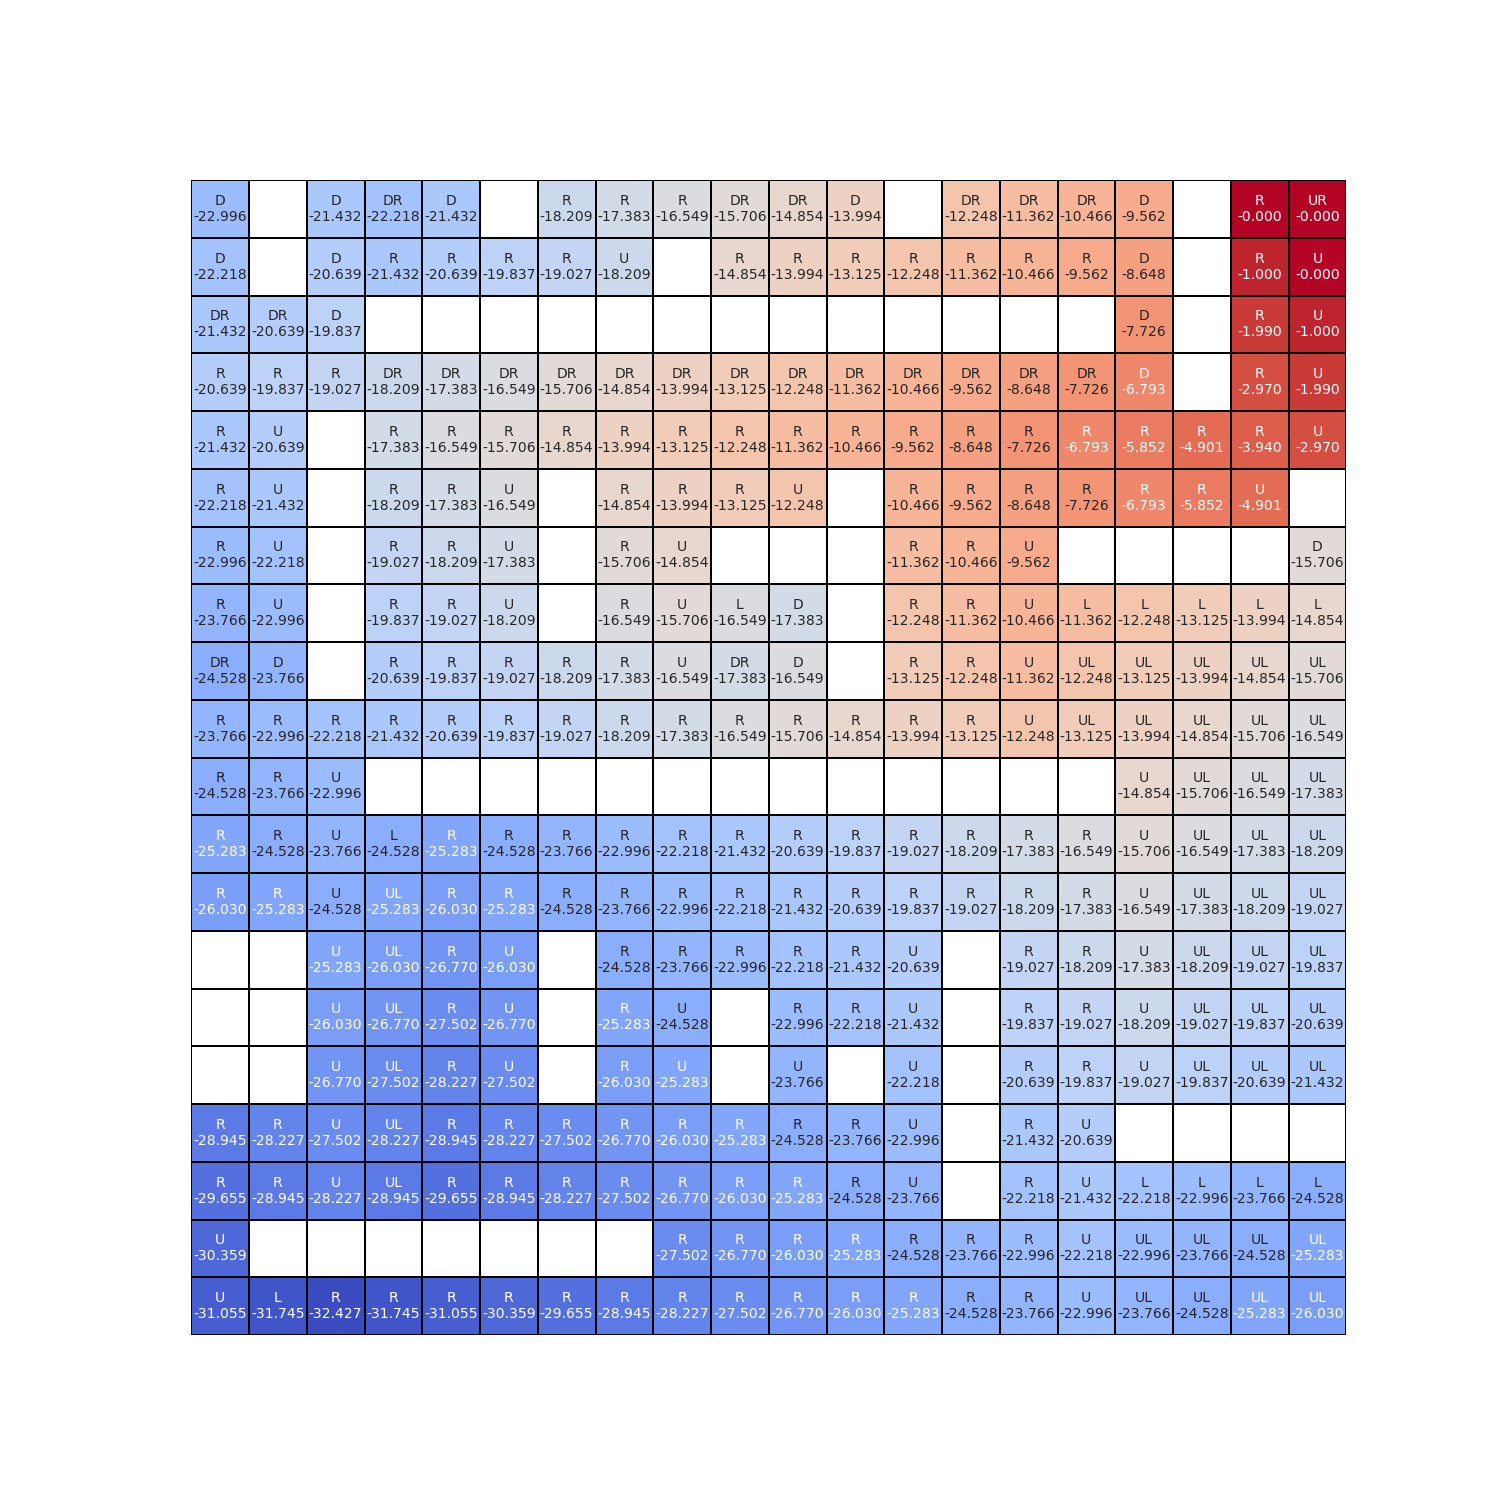

In [14]:
Image(filename=path_to_policy_fig)

<h2>References</h2>

[1] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, p. 59.<br>
[2] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, p. 74.<br>
[3] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, p. 75.<br>
[4] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, pp. 76-79.<br>
[5] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, p. 80.<br>